# Time-series Dataset Anomaly Detection

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
df = pd.read_csv('anomaly_detection.csv')
df.date = pd.to_datetime(df.date)

df.head()

,date,value,agency,anomaly
0,2020-01-01,197,AAA,0
1,2020-01-01,404,CCC,0
2,2020-01-01,153,BBB,0
3,2020-01-02,205,AAA,0
4,2020-01-02,401,CCC,0


In [6]:
df.query('anomaly == 1')

,date,value,agency,anomaly
24,2020-01-09,167,BBB,1
25,2020-01-09,411,CCC,1
26,2020-01-09,222,AAA,1
30,2020-01-11,390,CCC,1
31,2020-01-11,143,BBB,1
...,...,...,...,...
5557,2025-01-26,346,AAA,1
5558,2025-01-26,194,BBB,1
5562,2025-01-28,186,BBB,1
5563,2025-01-28,255,CCC,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     5574 non-null   datetime64[ns]
 1   value    5574 non-null   int64         
 2   agency   5574 non-null   object        
 3   anomaly  5574 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 174.3+ KB


<Axes: xlabel='date', ylabel='value'>

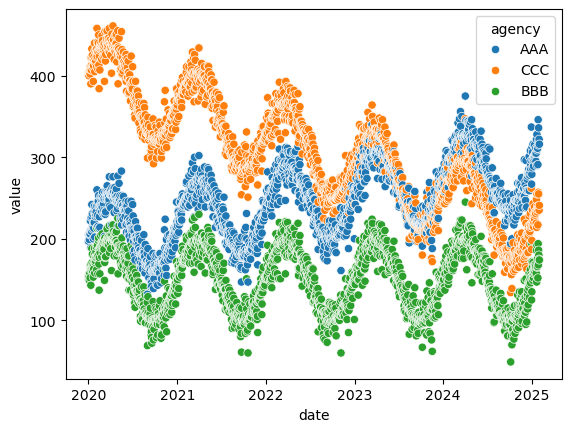

In [8]:
sns.scatterplot(data=df, x='date', y='value', hue='agency')

<Axes: xlabel='date', ylabel='value'>

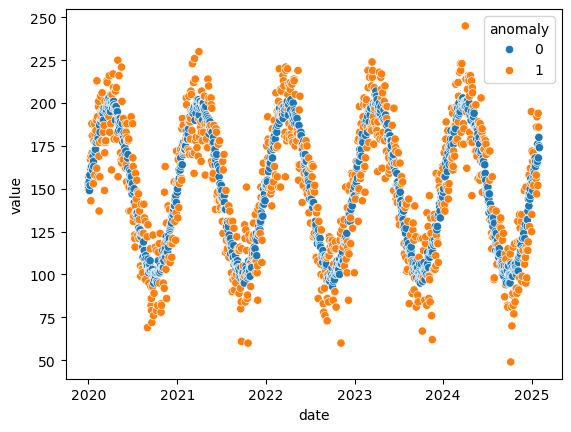

In [9]:
sns.scatterplot(data=df.query("agency=='BBB'"), x='date', y='value', hue='anomaly')

EDA

In [11]:
anomaly_counts = df['anomaly'].value_counts()
print("\nClass Dstribution:\n")
print(anomaly_counts)


Class Dstribution:

anomaly
0    3045
1    2529
Name: count, dtype: int64


In [12]:
df['date']

0      2020-01-01
1      2020-01-01
2      2020-01-01
3      2020-01-02
4      2020-01-02
          ...    
5569   2025-01-30
5570   2025-01-30
5571   2025-01-31
5572   2025-01-31
5573   2025-01-31
Name: date, Length: 5574, dtype: datetime64[ns]

In [13]:
df.set_index('date', inplace=True)

In [14]:
df = df.sort_index()

In [15]:
df.head()

,value,agency,anomaly
date,,,
2020-01-01,197,AAA,0
2020-01-01,404,CCC,0
2020-01-01,153,BBB,0
2020-01-02,205,AAA,0
2020-01-02,401,CCC,0


In [16]:
df.isnull().sum()

value      0
agency     0
anomaly    0
dtype: int64

Feature Engineering

In [18]:

# Extract time-based features using the index
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['year'] = df.index.year
df['day_of_year'] = df.index.dayofyear
df['day_of_week'] = df.index.dayofweek
df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)

# Compute rolling window statistics (for each agency)
df.sort_values(by=["agency", "date"], inplace=True)  # 'date' now part of index, still needed for sorting
df["rolling_mean_7"] = df.groupby("agency")["value"].transform(lambda x: x.rolling(7, min_periods=1).mean())
df["rolling_std_7"] = df.groupby("agency")["value"].transform(lambda x: x.rolling(7, min_periods=1).std())
df["rolling_mean_30"] = df.groupby("agency")["value"].transform(lambda x: x.rolling(30, min_periods=1).mean())
df["rolling_mean_365"] = df.groupby("agency")["value"].transform(lambda x: x.rolling(365, min_periods=1).mean())

#lagged values
df['val_lag1']=df['value'].shift(1)
df['val_lag2']=df['value'].shift(2)
df['val_lag3']=df['value'].shift(3)

df["diff_1"] = df["value"] - df["val_lag1"]
df["diff_7"] = df["value"] - df["rolling_mean_7"]
df["diff_30"] = df["value"] - df["rolling_mean_30"]

# Encode categorical variable
df["agency_encoded"] = df["agency"].astype("category").cat.codes

# Display the updated dataset
df.head()


,value,agency,anomaly,month,quarter,year,day_of_year,day_of_week,is_weekend,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_mean_365,val_lag1,val_lag2,val_lag3,diff_1,diff_7,diff_30,agency_encoded
date,,,,,,,,,,,,,,,,,,,,
2020-01-01,197,AAA,0,1,1,2020,1,2,0,197.000000,NaN,197.000000,197.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0
2020-01-02,205,AAA,0,1,1,2020,2,3,0,201.000000,5.656854,201.000000,201.000000,197.0,NaN,NaN,8.0,4.000000,4.000000,0
2020-01-03,205,AAA,0,1,1,2020,3,4,0,202.333333,4.618802,202.333333,202.333333,205.0,197.0,NaN,0.0,2.666667,2.666667,0
2020-01-04,200,AAA,0,1,1,2020,4,5,1,201.750000,3.947573,201.750000,201.750000,205.0,205.0,197.0,-5.0,-1.750000,-1.750000,0
2020-01-05,199,AAA,0,1,1,2020,5,6,1,201.200000,3.633180,201.200000,201.200000,200.0,205.0,205.0,-1.0,-2.200000,-2.200000,0


Using XGBoost Model for Anomaly Detection as it is a Supervised Data 

In [20]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Properly select multiple columns using a list
X = df[[
    "value", "year", "month", "day_of_week", "rolling_mean_30",
    "day_of_year", "rolling_mean_7", "rolling_std_7","diff_1","diff_7","diff_30",
    "rolling_mean_365", "val_lag1", "val_lag2", "val_lag3"
]]

y = df["anomaly"]

# Split data

# 80% train, 20% test in the sequence of the sorted time index 
split_index = int(len(df) * 0.8)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# Train XGBoost model
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
m = XGBClassifier(scale_pos_weight=scale_pos_weight)
m.fit(X_train, y_train)

# Predict
y_pred = m.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Output results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.9148
Precision: 0.9350
Recall: 0.8745
F1-score: 0.9037


Checking the importance of the Features

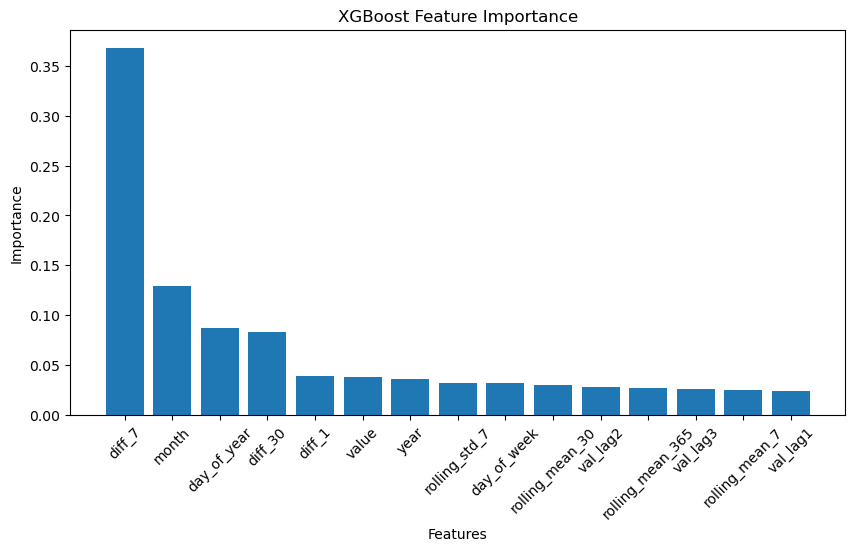

In [22]:
import matplotlib.pyplot as plt
import numpy as np
# Feature Importance Visualization
# Get feature importance
importance = m.feature_importances_
feature_names = X.columns

# Plot feature importance
plt.figure(figsize=(10, 5))
indices = np.argsort(importance)[::-1]  # Sort in descending order
plt.bar(range(len(importance)), importance[indices], align="center")
plt.xticks(range(len(importance)), feature_names[indices], rotation=45)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("XGBoost Feature Importance")
plt.show()


Confusion Matrix 

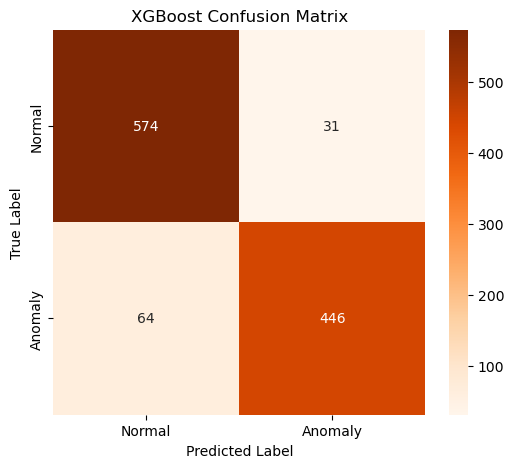

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Confusion Matrix Visualization
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost Confusion Matrix")
plt.show()


Doing Cross Validation

In [26]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(m, X, y, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean()}")


Cross-validation scores: [0.89865471 0.92376682 0.88520179 0.91390135 0.91113106]
Mean CV score: 0.906531144584618


### The mean CV score of 0.9065 suggests that the model has strong generalization ability. Overall, the model appears to perform well with a relatively stable performance across different splits.

Plotting Roc Curve 

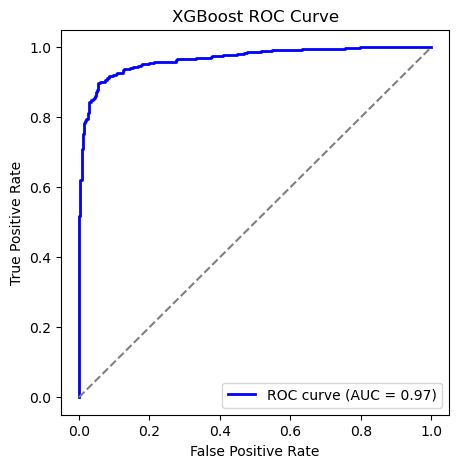

AUC Score: 0.9672


In [29]:
from sklearn.metrics import roc_curve, auc
# ROC Curve & AUC Score
# Predict probabilities
y_proba = m.predict_proba(X_test)[:, 1]  # Get the probability of the positive class

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Compute AUC
roc_auc = auc(fpr, tpr)

print(f"AUC Score: {roc_auc:.4f}")

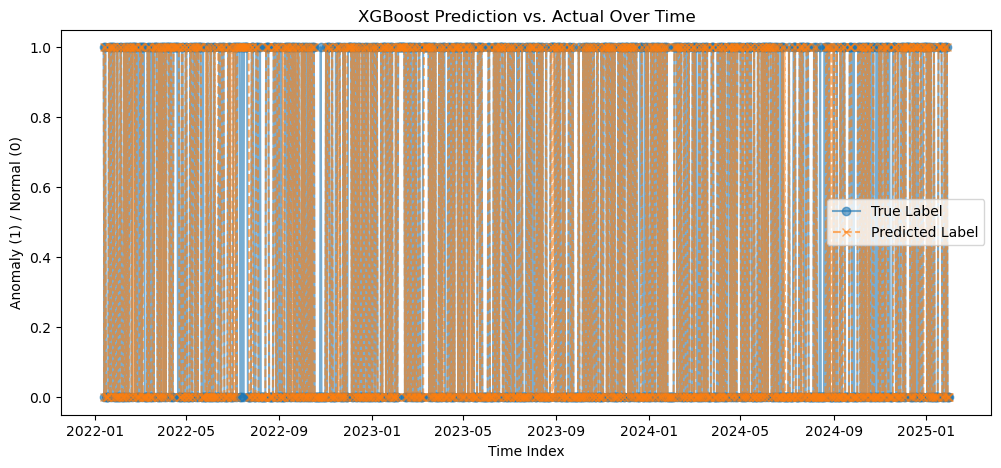

In [30]:
# Predicted vs. Actual Overall Time Series dataset Visualization 
df_results = X_test.copy()
df_results['True Label'] = y_test.values
df_results['Predicted Label'] = y_pred

# Plot time series
plt.figure(figsize=(12, 5))
plt.plot(df_results.index, df_results['True Label'], label="True Label", marker="o", linestyle="-", alpha=0.6)
plt.plot(df_results.index, df_results['Predicted Label'], label="Predicted Label", marker="x", linestyle="--", alpha=0.6)
plt.xlabel("Time Index")
plt.ylabel("Anomaly (1) / Normal (0)")
plt.title("XGBoost Prediction vs. Actual Over Time")
plt.legend()
plt.show()

Plotting Anomalies for Agency AAA

Text(0.5, 1.0, 'True vs Predicted Anomalies (AAA)')

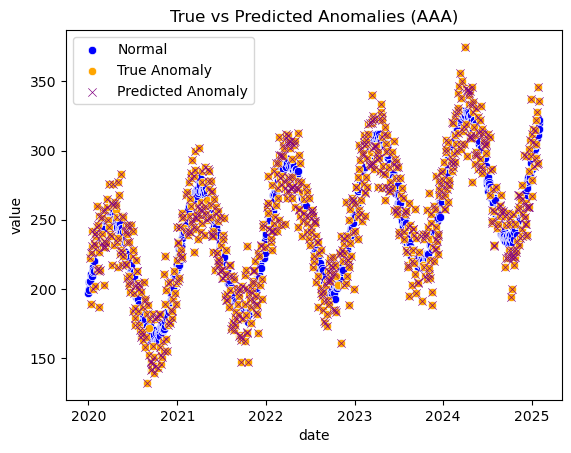

In [32]:
# Predicted vs. Actual for AAA agency
df_plot = df.query("agency=='AAA'").copy()
df_plot["predicted_anomaly"] = m.predict(df_plot[[
    "value", "year", "month", "day_of_week", "rolling_mean_30",
    "day_of_year", "rolling_mean_7", "rolling_std_7","diff_1","diff_7","diff_30",
    "rolling_mean_365", "val_lag1", "val_lag2", "val_lag3"
]])

# Plot normal data points (non-anomalies)
sns.scatterplot(data=df_plot[df_plot['anomaly'] == 0], x='date', y='value', color='blue', label='Normal')

# Plot true anomalies
sns.scatterplot(data=df_plot[df_plot['anomaly'] == 1], x='date', y='value', color='orange', label='True Anomaly', marker='o')

# Plot predicted anomalies
sns.scatterplot(data=df_plot[df_plot['predicted_anomaly'] == 1], x='date', y='value', color='purple', label='Predicted Anomaly', marker='x')

# Labels and legend
plt.title("True vs Predicted Anomalies (AAA)")

Plotting Anomolies for Agency BBB

Text(0.5, 1.0, 'True vs Predicted Anomalies (BBB)')

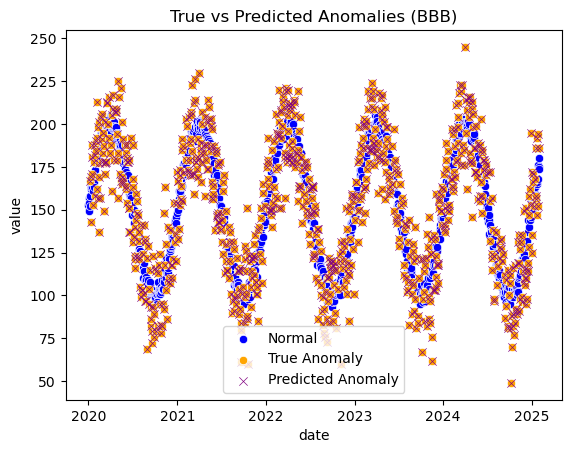

In [34]:
# Predicted vs. Actual for BBB agency
df_plot = df.query("agency=='BBB'").copy()
df_plot["predicted_anomaly"] = m.predict(df_plot[[
    "value", "year", "month", "day_of_week", "rolling_mean_30",
    "day_of_year", "rolling_mean_7", "rolling_std_7","diff_1","diff_7","diff_30",
    "rolling_mean_365", "val_lag1", "val_lag2", "val_lag3"
]])

# Plot normal data points (non-anomalies)
sns.scatterplot(data=df_plot[df_plot['anomaly'] == 0], x='date', y='value', color='blue', label='Normal')

# Plot true anomalies
sns.scatterplot(data=df_plot[df_plot['anomaly'] == 1], x='date', y='value', color='orange', label='True Anomaly', marker='o')

# Plot predicted anomalies
sns.scatterplot(data=df_plot[df_plot['predicted_anomaly'] == 1], x='date', y='value', color='purple', label='Predicted Anomaly', marker='x')

# Labels and legend
plt.title("True vs Predicted Anomalies (BBB)")


Plotting Anomalies for agency CCC

Text(0.5, 1.0, 'True vs Predicted Anomalies (CCC)')

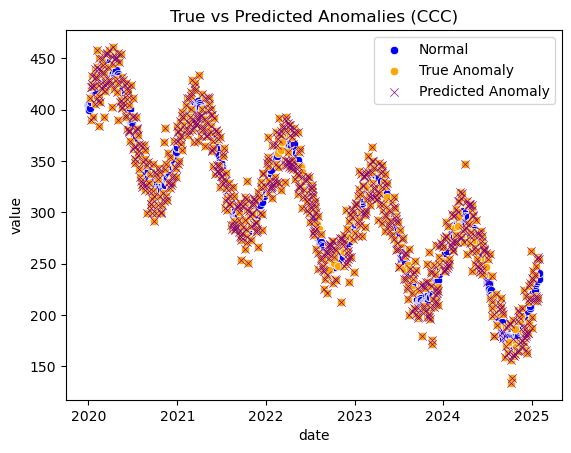

In [36]:
# Predicted vs. Actual for CCC agency
df_plot = df.query("agency=='CCC'").copy()
df_plot["predicted_anomaly"] = m.predict(df_plot[[
    "value", "year", "month", "day_of_week", "rolling_mean_30",
    "day_of_year", "rolling_mean_7", "rolling_std_7","diff_1","diff_7","diff_30",
    "rolling_mean_365", "val_lag1", "val_lag2", "val_lag3"
]])

# Plot normal data points (non-anomalies)
sns.scatterplot(data=df_plot[df_plot['anomaly'] == 0], x='date', y='value', color='blue', label='Normal')

# Plot true anomalies
sns.scatterplot(data=df_plot[df_plot['anomaly'] == 1], x='date', y='value', color='orange', label='True Anomaly', marker='o')

# Plot predicted anomalies
sns.scatterplot(data=df_plot[df_plot['predicted_anomaly'] == 1], x='date', y='value', color='purple', label='Predicted Anomaly', marker='x')

# Labels and legend
plt.title("True vs Predicted Anomalies (CCC)")

In [37]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_train = y_train.values.ravel() if hasattr(y_train, 'values') else y_train

# Define hyperparameter search space
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Initialize XGBoost using CPU (tree_method='hist')
xgb = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    tree_method='hist'  
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    error_score='raise'  
)

# Fit the model
grid_search.fit(X_train, y_train)

# Output the best hyperparameters
print(f"Best parameters: {grid_search.best_params_}")

# Predict using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print evaluation results
print(f"Optimized Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.9}
Optimized Accuracy: 0.9139
Precision: 0.9423
Recall: 0.8647
F1-score: 0.9018
